# PART 3

In [23]:
from pymongo import MongoClient
import pandas as pd

def query_to_dataframe(query, database):
    '''
    custom function to create a dataframe of query results
    from a mongodb database
    '''
    
    client = MongoClient(host="midgard09", port=27017)
    weather_data = client.pitds_weather_data[database]
    
    entries = []
    for entry in weather_data.find(query):
        entries.append(entry)
      
    if len(entries)==0: # no hits for the query
        return None
    else:
        return pd.DataFrame(entries).drop(columns=["_id"])

In [24]:
# Get happiness data
happiness = query_to_dataframe({}, database="happiness_data")

# Get 2018 weather data
weather_2018 = pd.read_excel("cleaned_2018_data.xlsx")

# Get station locations
stations = query_to_dataframe({}, database="station_cordinates")

In [25]:
happiness

,area_codes,area_names,avg_rating,high_7_8,latitude,longitude,low_0_4,medium_5_6,sample_size,vhigh_9_10
0,E12000001,NORTH EAST,7.34,39.06,55.0,-1.9,10.77,17.05,11310,33.13
1,E12000002,NORTH WEST,7.39,39.10,54.0,-2.6,10.17,16.82,19460,33.91
2,E12000003,YORKSHIRE AND THE HUMBER,7.41,38.56,53.6,-1.2,10.21,16.60,13110,34.63
3,E12000004,EAST MIDLANDS,7.51,38.62,53.0,-0.8,8.66,16.74,7880,35.99
4,E12000005,WEST MIDLANDS,7.43,41.72,52.5,-2.3,8.61,17.59,11940,32.08
5,E12000006,EAST,7.51,41.69,52.2,0.4,8.53,15.69,9960,34.09
6,E12000007,LONDON,7.38,42.20,51.5,-0.1,8.32,18.30,13560,31.18
7,E12000008,SOUTH EAST,7.54,40.88,51.3,-0.5,7.97,15.83,19490,35.32
8,E12000009,SOUTH WEST,7.50,40.44,51.0,-3.2,8.79,15.92,13600,34.84
9,W92000004,WALES,7.44,39.45,51.5,-3.2,9.56,16.54,19540,34.45


In [26]:
weather_2018.head()

,af_days,month,rain_mm,station_name,sun_hours,tmax_degC,tmin_degC,year
0,0,1,117.2,aberporth,53.5,8.4,3.8,2018
1,10,2,48.6,aberporth,91.3,6.3,1.3,2018
2,6,3,97.0,aberporth,100.6,7.7,2.3,2018
3,0,4,70.6,aberporth,152.2,12.1,6.4,2018
4,0,5,33.4,aberporth,219.4,15.3,8.1,2018


In [27]:
#weather_2018.drop(columns=["Unnamed: 0"], inplace=True)
weather_2018.head()

,af_days,month,rain_mm,station_name,sun_hours,tmax_degC,tmin_degC,year
0,0,1,117.2,aberporth,53.5,8.4,3.8,2018
1,10,2,48.6,aberporth,91.3,6.3,1.3,2018
2,6,3,97.0,aberporth,100.6,7.7,2.3,2018
3,0,4,70.6,aberporth,152.2,12.1,6.4,2018
4,0,5,33.4,aberporth,219.4,15.3,8.1,2018


In [28]:
stations = stations.set_index("station").drop(columns=["label"])
stations.head()

,latitude,longitude
station,,
aberporth,52.139,-4.570
armagh,54.352,-6.649
ballypatrick,55.181,-6.153
bradford,53.813,-1.772
braemar,57.006,-3.396


### Join stations and happiness data

In [29]:
import numpy as np

def square(x):
    return x*x

def get_shortest_distance(a, b):
    x = b.longitude - a.longitude
    y = b.latitude - a.latitude
    
    xx = x.apply(func=square)
    yy = y.apply(func=square)
    
    return np.sqrt(xx+yy).sort_values().index[0]
     
    
def get_area_index(station, stations, areas):
    '''
    custom function to identify the area to which a given station belongs.
    The fucntion chooses the area that has the least straight line distance from
    the station. The straight line distance betwen a stationa an area is determined 
    using the coordiates of the station and the coordinate sof the area.
    
    param: station - the name of the station on interest
    param: stations - the names and locations of all stations
    param: areas - the names and locations of all stations
    
    return: area - the name of the closest area
    '''
    from_location = stations.loc[station]
    index = get_shortest_distance(a=from_location, b=areas)
    
    return areas.index[index]


def get_nearest_area(station, stations, happiness):
    
    h = happiness.copy(deep=True)
    areas = pd.concat([h.area_codes, h.latitude, h.longitude], axis=1)
    
    return h.area_codes.loc[get_area_index(station, stations, areas)]

In [30]:
get_nearest_area("ballypatrick", stations, happiness)

'S92000003'

In [31]:
areas = []
for station in stations.index:
    area = get_nearest_area(station, stations, happiness)
    areas.append(area)
    
station_area = pd.concat([pd.Series(stations.index), pd.Series(areas, name="area")], axis=1)
station_area

,station,area
0,aberporth,W92000004
1,armagh,S92000003
2,ballypatrick,S92000003
3,bradford,E12000003
4,braemar,S92000003
5,camborne,E12000009
6,cambridge,E12000006
7,cardiff,W92000004
8,chivenor,E12000009
9,cwmystwyth,W92000004


In [32]:
station_area[:18]

,station,area
0,aberporth,W92000004
1,armagh,S92000003
2,ballypatrick,S92000003
3,bradford,E12000003
4,braemar,S92000003
5,camborne,E12000009
6,cambridge,E12000006
7,cardiff,W92000004
8,chivenor,E12000009
9,cwmystwyth,W92000004


In [33]:
station_area.area.unique()

array(['W92000004', 'S92000003', 'E12000003', 'E12000009', 'E12000006',
       'E12000001', 'E12000007', 'E12000008', 'E12000002', 'E12000005',
       'E12000004'], dtype=object)

### merge station_area with averaged weather data

In [34]:
def get_season_average(months, data):
    
    season = data[data.month == months[0]]
    season = season.set_index("station_name")
    
    # cummulatively sum up data for each month
    for month in range(1, len(months)):
        season = season + data[data.month == months[month]].set_index("station_name")
    
    season.drop(columns=["month","year"], inplace=True) # drop meaningless averages
    
    # divide by the number of months to return averages
    return season/len(months)


# Get averages for the whole year
w_2018_avg = get_season_average(months=[i for i in range(1,13)], data=weather_2018)

In [35]:
w_2018_avg.head()

,af_days,rain_mm,sun_hours,tmax_degC,tmin_degC
station_name,,,,,
aberporth,1.333333,83.683333,132.400000,13.166667,7.683333
armagh,2.750000,67.458333,114.141667,13.650000,6.033333
ballypatrick,2.166667,103.833333,35.252778,11.841667,6.016667
bradford,3.333333,58.483333,126.133333,13.741667,6.366667
braemar,10.083333,71.308333,29.852778,11.208333,2.908333


In [36]:
# Join weather and area data
weather_area = pd.concat([w_2018_avg, station_area.set_index("station")], axis=1, sort=True)
weather_area

,af_days,rain_mm,sun_hours,tmax_degC,tmin_degC,area
aberporth,1.333333,83.683333,132.400000,13.166667,7.683333,W92000004
armagh,2.750000,67.458333,114.141667,13.650000,6.033333,S92000003
ballypatrick,2.166667,103.833333,35.252778,11.841667,6.016667,S92000003
bradford,3.333333,58.483333,126.133333,13.741667,6.366667,E12000003
braemar,10.083333,71.308333,29.852778,11.208333,2.908333,S92000003
camborne,0.833333,99.683333,126.883333,14.241667,8.825000,E12000009
cambridge,2.916667,41.483333,41.833333,15.425000,6.800000,E12000006
cardiff,2.833333,99.300000,39.819444,15.433333,7.575000,W92000004
chivenor,1.833333,69.116667,43.766667,15.200000,8.175000,E12000009
cwmystwyth,NaN,NaN,NaN,NaN,NaN,W92000004


## store weather_area in database

In [37]:
weather_area.reset_index(inplace=True)
weather_area.rename(columns={"index":"station"}, inplace=True)
weather_area.head()

,station,af_days,rain_mm,sun_hours,tmax_degC,tmin_degC,area
0,aberporth,1.333333,83.683333,132.400000,13.166667,7.683333,W92000004
1,armagh,2.750000,67.458333,114.141667,13.650000,6.033333,S92000003
2,ballypatrick,2.166667,103.833333,35.252778,11.841667,6.016667,S92000003
3,bradford,3.333333,58.483333,126.133333,13.741667,6.366667,E12000003
4,braemar,10.083333,71.308333,29.852778,11.208333,2.908333,S92000003


In [38]:
from pymongo import MongoClient

def make_lineObj(line, data):
    ''' create a dict object of a specified row
        of a dataframe
    '''

    obj = {}
    
    for column in data.columns:
        obj[column] = data[column].iloc[line]
        
    return obj

def storeObj(obj):
    
    collection = "weather_area_data"
    
    # Config database server
    client = MongoClient(host="midgard09", port=27017)
    db = client.pitds_weather_data
    weather_data = db[collection]
    
    # Store document
    weather_data.insert_one(obj)
    print("successfully stored: ", obj["area"])
    
    
for row in range(0, len(weather_area)):
    storeObj(make_lineObj(row, weather_area))

successfully stored:  W92000004
successfully stored:  S92000003
successfully stored:  S92000003
successfully stored:  E12000003
successfully stored:  S92000003
successfully stored:  E12000009
successfully stored:  E12000006
successfully stored:  W92000004
successfully stored:  E12000009
successfully stored:  W92000004
successfully stored:  S92000003
successfully stored:  E12000001
successfully stored:  E12000007
successfully stored:  S92000003
successfully stored:  E12000008
successfully stored:  E12000009
successfully stored:  S92000003
successfully stored:  S92000003
successfully stored:  E12000006
successfully stored:  E12000006
successfully stored:  S92000003
successfully stored:  E12000002
successfully stored:  E12000008
successfully stored:  S92000003
successfully stored:  E12000002
successfully stored:  E12000005
successfully stored:  E12000005
successfully stored:  E12000003
successfully stored:  E12000008
successfully stored:  S92000003
successfully stored:  E12000004
successf

# use mongodb aggregation to join the weather and happiness data

In [41]:
def flatten(aggregate_obj, to_extract):
    '''
    Custom function to flatten a nested dictionary that
    results from a mongodb aggregation.
    '''
    # Extracct nested entires
    extract = aggregate_obj[to_extract][0]
    
    # discard redundant dict items
    aggregate_obj.pop(to_extract)
    aggregate_obj.pop("_id")
    extract.pop("_id")
    
    # return flattened dictionary
    return {**aggregate_obj, **extract}
    
    
def aggregation_to_dataframe(query, database):
    '''
    Custom function that returns the results of a mongodb 
    aggregation in a dataframe
    '''
    
    # config database
    client = MongoClient(host="midgard09", port=27017)
    weather_data = client.pitds_weather_data[database]
    
    entries = []
    
    # collect entries
    for entry in weather_data.aggregate(query):
        
        flat_entry = flatten(aggregate_obj=entry, to_extract="happiness")
        entries.append(flat_entry)
        
    #create dataframe
    return pd.DataFrame(entries)

In [47]:
# specify aggregation details
query = [{
          '$lookup': {
            'from': 'happiness_data', 
            'localField': 'area', 
            'foreignField': 'area_codes', 
            'as': 'happiness'
          }
        }
       ]

database = "weather_area_data"

# Join weather and happiness data
joined = aggregation_to_dataframe(query, database)
joined.head()

,af_days,area,area_codes,area_names,avg_rating,high_7_8,latitude,longitude,low_0_4,medium_5_6,rain_mm,sample_size,station,sun_hours,tmax_degC,tmin_degC,vhigh_9_10
0,1.333333,W92000004,W92000004,WALES,7.44,39.45,51.5,-3.2,9.56,16.54,83.683333,19540,aberporth,132.400000,13.166667,7.683333,34.45
1,2.750000,S92000003,S92000003,SCOTLAND,7.45,39.75,56.0,-3.2,9.16,16.90,67.458333,22760,armagh,114.141667,13.650000,6.033333,34.19
2,2.166667,S92000003,S92000003,SCOTLAND,7.45,39.75,56.0,-3.2,9.16,16.90,103.833333,22760,ballypatrick,35.252778,11.841667,6.016667,34.19
3,3.333333,E12000003,E12000003,YORKSHIRE AND THE HUMBER,7.41,38.56,53.6,-1.2,10.21,16.60,58.483333,13110,bradford,126.133333,13.741667,6.366667,34.63
4,10.083333,S92000003,S92000003,SCOTLAND,7.45,39.75,56.0,-3.2,9.16,16.90,71.308333,22760,braemar,29.852778,11.208333,2.908333,34.19


In [48]:
# Drop repeated column that was used for joining
joined.drop(columns=["area"], inplace=True)
cols = ["area_codes", "area_names","station", "latitude", "longitude",
       "low_0_4","medium_5_6", "high_7_8","vhigh_9_10", "avg_rating",
       "af_days", "rain_mm", "sun_hours" , "tmax_degC","tmin_degC"]
joined[cols]

,area_codes,area_names,station,latitude,longitude,low_0_4,medium_5_6,high_7_8,vhigh_9_10,avg_rating,af_days,rain_mm,sun_hours,tmax_degC,tmin_degC
0,W92000004,WALES,aberporth,51.5,-3.2,9.56,16.54,39.45,34.45,7.44,1.333333,83.683333,132.400000,13.166667,7.683333
1,S92000003,SCOTLAND,armagh,56.0,-3.2,9.16,16.90,39.75,34.19,7.45,2.750000,67.458333,114.141667,13.650000,6.033333
2,S92000003,SCOTLAND,ballypatrick,56.0,-3.2,9.16,16.90,39.75,34.19,7.45,2.166667,103.833333,35.252778,11.841667,6.016667
3,E12000003,YORKSHIRE AND THE HUMBER,bradford,53.6,-1.2,10.21,16.60,38.56,34.63,7.41,3.333333,58.483333,126.133333,13.741667,6.366667
4,S92000003,SCOTLAND,braemar,56.0,-3.2,9.16,16.90,39.75,34.19,7.45,10.083333,71.308333,29.852778,11.208333,2.908333
5,E12000009,SOUTH WEST,camborne,51.0,-3.2,8.79,15.92,40.44,34.84,7.50,0.833333,99.683333,126.883333,14.241667,8.825000
6,E12000006,EAST,cambridge,52.2,0.4,8.53,15.69,41.69,34.09,7.51,2.916667,41.483333,41.833333,15.425000,6.800000
7,W92000004,WALES,cardiff,51.5,-3.2,9.56,16.54,39.45,34.45,7.44,2.833333,99.300000,39.819444,15.433333,7.575000
8,E12000009,SOUTH WEST,chivenor,51.0,-3.2,8.79,15.92,40.44,34.84,7.50,1.833333,69.116667,43.766667,15.200000,8.175000
9,W92000004,WALES,cwmystwyth,51.5,-3.2,9.56,16.54,39.45,34.45,7.44,NaN,NaN,NaN,NaN,NaN


In [49]:
joined[cols].to_excel("joined.xlsx")

In [50]:
# Visualize joined data
import seaborn as sns
import matplotlib.pyplot as plt

def plot_scatter(happiness_rating):
    '''
    custom fucntion to plot several attributes against a
    specified happiness metric on a scatter plot
    '''
    rows = 2
    cols = 3
    fig, ax = plt.subplots(rows,cols)

    to_plot = ["rain_mm", "sun_hours", "tmax_degC", "tmin_degC","af_days"]
    plot_index = 0

    for row in range(0, rows):
        for col in range(0, cols):
        
            axes = ax[row][col]
            sns.scatterplot(data=joined, x=to_plot[plot_index], y=happiness_rating, ax=axes)
            axes.set_xlabel("")
            axes.set_xticklabels("")
            axes.set_yticklabels("")
            axes.set_title(to_plot[plot_index])
            plot_index += 1
        
            if plot_index >= len(to_plot):
                break

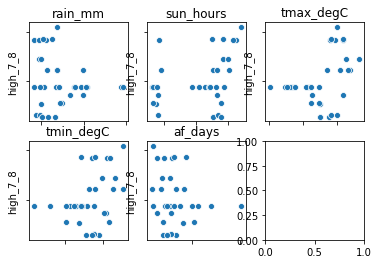

In [51]:
plot_scatter(happiness_rating="high_7_8")

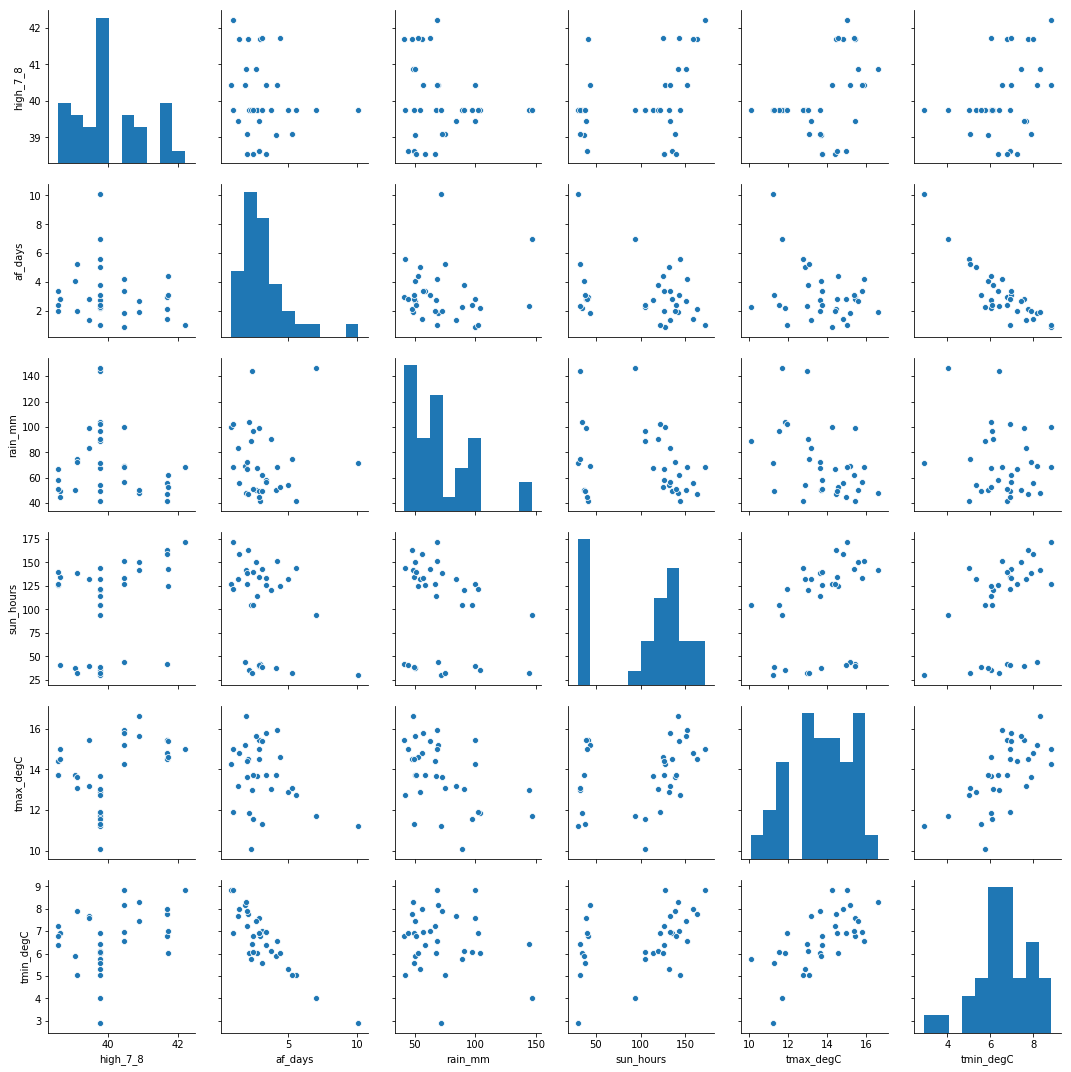

In [75]:
to_plot = ["high_7_8", "af_days", "rain_mm", "sun_hours" , "tmax_degC","tmin_degC"]
sns.pairplot(joined[to_plot])